## Kalman Filter 

Sources:
- https://github.com/Ugenteraan/Kalman-Filter-Scratch
- http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf
- https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html

### From Scratch

In [102]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [103]:
# initial conditions

current_velocity = 2
current_displacement = 0
current_acceleration = 0
total_time = 100
#acceleration_dict holds the value of acceleration at different time steps.
acceleration_dict = {
    0:0,
    5:2,
    10: 8,
    20:-2,
    40:5,
    45: 9,
    60:-3,
    85:0
}

In [104]:
true_values = []

for t in range(1, total_time+1):
    
    # x = x0 + v0*t + (1/2)*a*(t)^2
    # instantaneous: t = 1, x0 = x@(t-1), v0 = v@(t-1)
    current_displacement = current_displacement + current_velocity + 0.5*current_acceleration
    
    #get the acceleration from the dictionary
    try:
        current_acceleration = acceleration_dict[t]
    except KeyError:
        pass
    
    # v = v0 + a*t
    current_velocity = current_velocity + current_acceleration
    
    #append displacement,velocity and acceleration in tuples.
    true_values.append((current_displacement, current_velocity, current_acceleration))



In [105]:
# measured values (true value + noise)

error_range = [700, 30, 15]
measurement = []

for item in true_values:
    d, v, a = item
    
    random_err = [random.randint(-1*error_range[0], error_range[0]), random.randint(-1*error_range[1], error_range[1]), random.randint(-1*error_range[2], error_range[2])]
    
    new_displacement = d + random_err[0] if d+random_err[0] > 0 else 0 # displacement >= 0
    new_velocity = v + random_err[1]
    new_acceleration = a + random_err[2]
    
    measurement.append((new_displacement, new_velocity, new_acceleration))

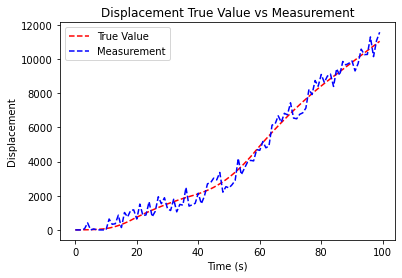

In [106]:
# plot displacement

plt.plot([i for i in range(total_time)], [y[0] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[0] for y in measurement], 'b--', label='Measurement')

plt.title("Displacement True Value vs Measurement")
plt.ylabel("Displacement")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

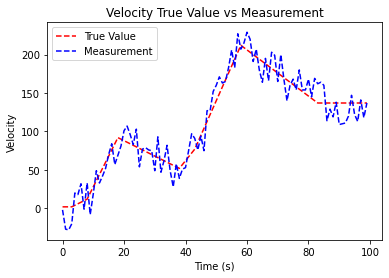

In [107]:
# plot velocity

plt.plot([i for i in range(total_time)], [y[1] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[1] for y in measurement], 'b--', label='Measurement')

plt.title("Velocity True Value vs Measurement")
plt.ylabel("Velocity")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

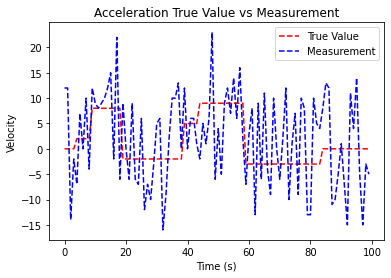

In [108]:
# plot acceleration

plt.plot([i for i in range(total_time)], [y[2] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[2] for y in measurement], 'b--', label='Measurement')

plt.title("Acceleration True Value vs Measurement")
plt.ylabel("Velocity")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

In [110]:
# kalman filter

# inital guess
# elem 0 = displacement, elem 1 = velocity
x_k = np.asarray([30,20])

# estimate error covariance
# noise model 1: process noise
Q = np.asarray([[0.004,0.002],[0.002,0.001]])

# transition matrix
# displacement is updated with prev disp + curr vel while velocity is updated with prev vel (assuming we have no knowledge about the acceleration)
A = np.asarray([[1,1],[0,1]])

# measurement error
# this is higher than estimation error since we know our measurement contains a lot of noises.
# noise model 2: observation noise
R = np.asarray([[0.4,0.01],[0.04,0.01]])

# observation matrix
# we want every state from our state vector.
H = np.asarray([[1,0],[0,1]])

# error matrix
# measure of the estimated accuracy of the state estimate
P = np.asarray([[0,0],[0,0]])

In [111]:
# estimated values

estimation = []

for k_loop in range(total_time):
    
    # z_k is the measurement at every step
    # z_k = [x, v]
    z_k = np.asarray([measurement[k_loop][0], measurement[k_loop][1]])
    
    x_k = A.dot(x_k) # predict estimate
    P = (A.dot(P)).dot(A.T) + Q # predict error covariance
    
    K = (P.dot(H.T)).dot(np.linalg.inv((H.dot(P).dot(H.T)) + R)) # update Kalman Gain
    x_k = x_k + K.dot((z_k - H.dot(x_k))) # update estimate
    
    P = (np.identity(2) - K.dot(H)).dot(P) # update error covariance
    
    estimation.append((x_k[0], x_k[1]))

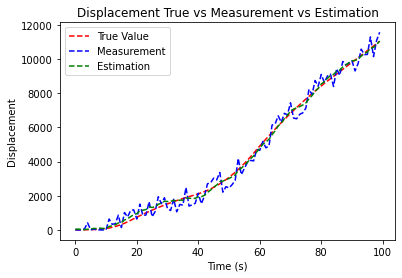

In [112]:
# plot displacement

plt.plot([i for i in range(total_time)], [y[0] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[0] for y in measurement], 'b--', label='Measurement')
plt.plot([i for i in range(total_time)], [y[0] for y in estimation], 'g--', label='Estimation')

plt.title("Displacement True vs Measurement vs Estimation")
plt.ylabel("Displacement")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

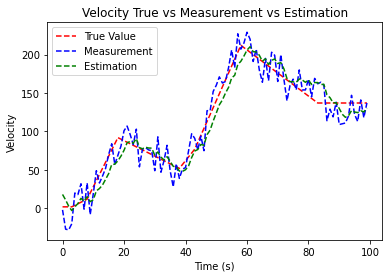

In [113]:
# plot velocity

plt.plot([i for i in range(total_time)], [y[1] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[1] for y in measurement], 'b--', label='Measurement')
plt.plot([i for i in range(total_time)], [y[1] for y in estimation], 'g--', label='Estimation')

plt.title("Velocity True vs Measurement vs Estimation")
plt.ylabel("Velocity")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

### Using FilterPy Library

In [114]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [126]:
# create kalman filter

f = KalmanFilter(dim_x=2, dim_z=2)

f.x = np.array([[30.],[20.]]) # position, velocity
f.F = np.array([[1.,1.], [0.,1.]]) # state transition matrix
f.H = np.array([[1.,0.],[0.,1.]]) # Measurement function
f.P = np.asarray([[0.,0.],[0.,0.]]) # covariance matrix
f.R = np.asarray([[0.4,0.01],[0.04,0.01]]) # state uncertainty
f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13) # process uncertainty

In [127]:
# estimated values

library_estimation = []

for t in range(total_time):
    z_k = np.asarray([measurement[t][0], measurement[t][1]])
    f.predict()
    f.update(z_k)
    
    library_estimation.append((f.x[0], f.x[1]))

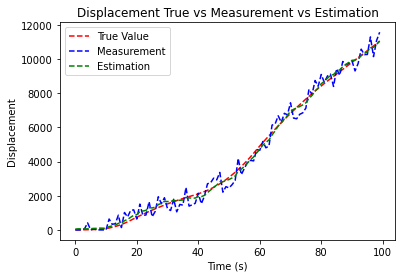

In [128]:
# plot displacement

plt.plot([i for i in range(total_time)], [y[0] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[0] for y in measurement], 'b--', label='Measurement')
plt.plot([i for i in range(total_time)], [y[0] for y in library_estimation], 'g--', label='Estimation')

plt.title("Displacement True vs Measurement vs Estimation")
plt.ylabel("Displacement")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

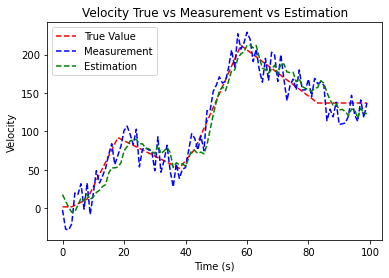

In [129]:
# plot velocity

plt.plot([i for i in range(total_time)], [y[1] for y in true_values], 'r--', label='True Value')
plt.plot([i for i in range(total_time)], [y[1] for y in measurement], 'b--', label='Measurement')
plt.plot([i for i in range(total_time)], [y[1] for y in library_estimation], 'g--', label='Estimation')

plt.title("Velocity True vs Measurement vs Estimation")
plt.ylabel("Velocity")
plt.xlabel("Time (s)")
plt.legend()
plt.show()